In [11]:
# import cv2 as cv 
import numpy as np 
import matplotlib.pyplot as plt 

- Use all the data to get an initial model approximation 
- remove the outliers 

BUT RANSAC: \
    - uses smallest set of points \
    - increases number of points consistent to the model 

s -> no of points you will choose to fit\
p -> prob of success you want \
e -> proportion outliers? \
   then,  - proportion inliers = 1-e 

N >= (log(1-p))/(log(1-(1-e)^s))
so, N is how many times I need to repeat to get the optimal inliers? 

In [6]:
def getN(p, e, s):
    N = np.log(1-p) / np.log(1-(1-e)**s)
    return np.ceil(N )

In [10]:
getN(0.99, 0.05, 2), getN(0.99, 0.5, 2)

(2.0, 17.0)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_15420\3678480911.py:2: RuntimeWarning: divide by zero encountered in log
  N = np.log(1-p) / np.log(1-(1-e)**s)
C:\Users\OMEN\AppData\Local\Temp\ipykernel_15420\3678480911.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  N = np.log(1-p) / np.log(1-(1-e)**s)


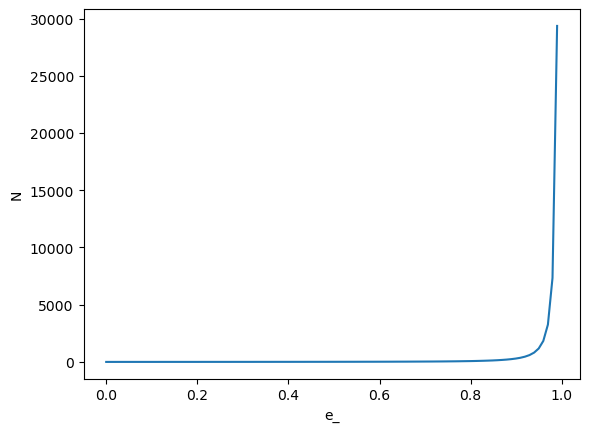

In [13]:
#exploring relation of N with other parameters 

#N and e
p = 0.95
s = 2

e_ = np.linspace(0,1, 100)
N = [getN(p,e,s) for e in e_]

plt.plot(e_, N)
plt.xlabel('e_')
plt.ylabel('N')
plt.show() 

[2 3 4 5 6 7]
[74.0, 373.0, 1871.0, 9361.0, 46807.0, 234041.0]


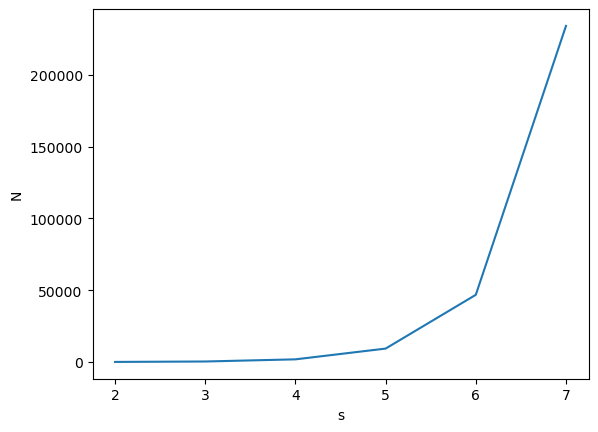

In [21]:
# N and s 
s_ = np.arange(2,8)
print(s_)

p=0.95
e = 0.80

N = [getN(p,e,s) for s in s_]
print(N)
plt.plot(s_, N)
plt.xlabel('s')
plt.ylabel('N')
plt.show()

In [22]:
#y=mx+c, m and c are parameters 
#linear model 
def getY(p, x):
    m,c = p 
    return m*x + c 

In [23]:
#getting the inliers that lie close to the line taken at particular N 
def getInliers(p, data, thres):
    inliers = []
    for point in data: 
        x,y = point 
        y_pred = getY(p, x)
        if(abs(y_pred-y))<thres:
            inliers.append(point)
    return inliers 

(100,) (100,)


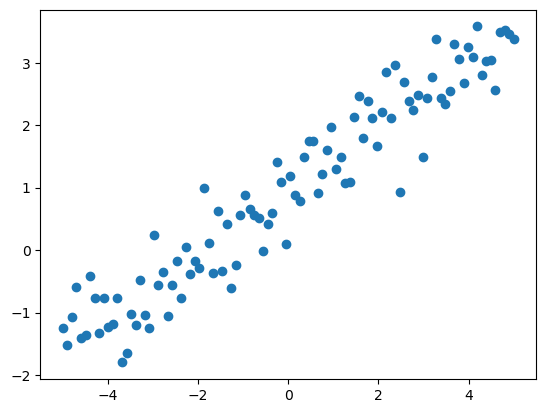

In [30]:
np.random.seed(42)
x = np.linspace(-5, 5, 100)
y = 0.5 * x + 1.0 + np.random.normal(0, 0.5, size=x.size)
print(x.shape, y.shape)
plt.scatter(x, y)

(170,) (170,)


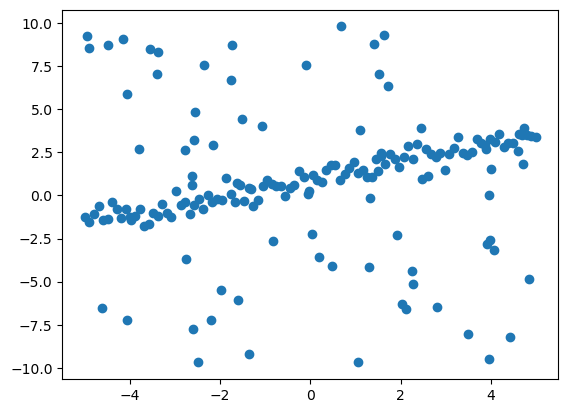

In [32]:
# Add some outliers
n_outliers = 40
x_outliers = np.random.uniform(-5, 5, n_outliers)
y_outliers = np.random.uniform(-10, 10, n_outliers)

x = np.concatenate((x, x_outliers))
y = np.concatenate((y, y_outliers))
print(x.shape, y.shape)
plt.scatter(x, y)

In [36]:
data = np.column_stack((x, y))
data.shape 

(170, 2)

[[-4.15860035  9.07857154]
 [-2.15159506  2.90345581]]


(array([[-4.15860035,  1.        ],
        [-2.15159506,  1.        ]]),
 -3.0767809885028052,
 -3.7165309557617023)

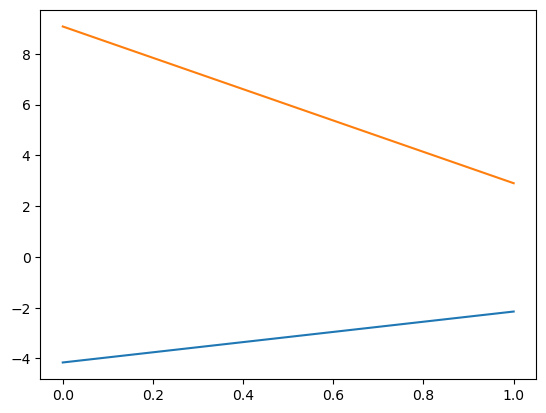

In [44]:
sample = data[np.random.choice(data.shape[0], 2)]
print(sample)
plt.plot (sample)
x_sample, y_sample = sample[:, 0], sample[:, 1]
A = np.vstack([x_sample, np.ones(len(x_sample))]).T
m, b = np.linalg.lstsq(A, y_sample, rcond=None)[0]
A, m, b 

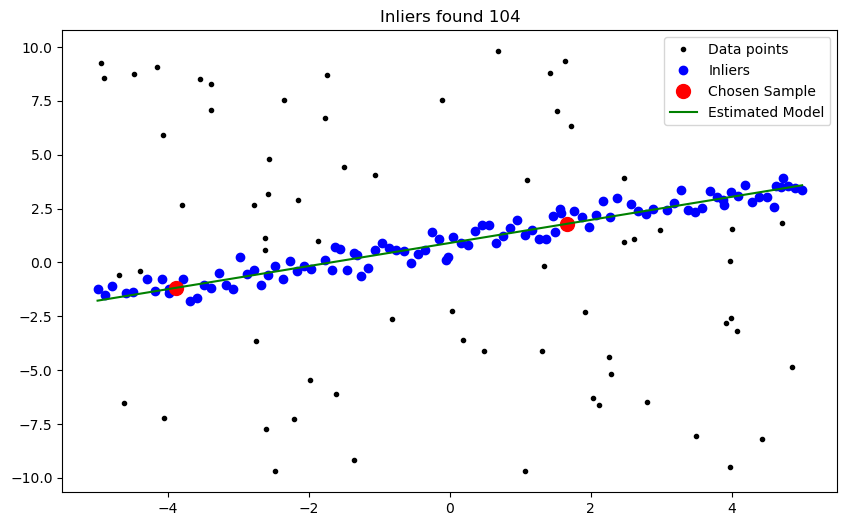

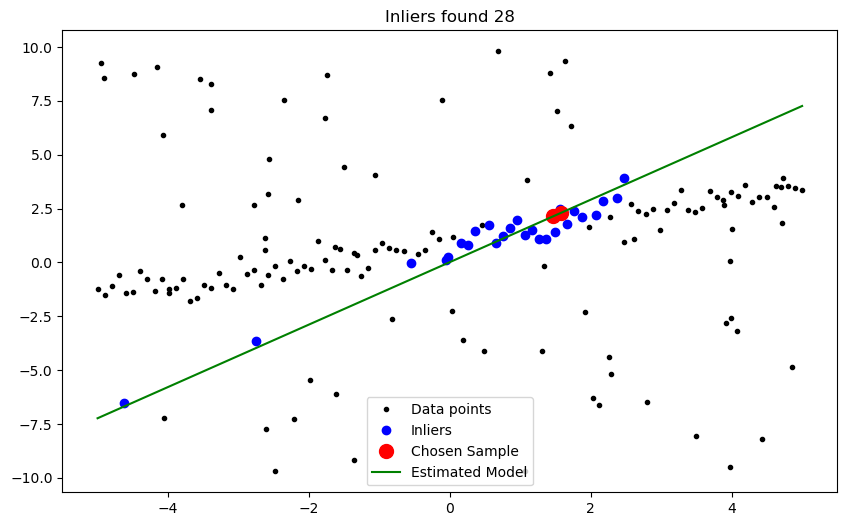

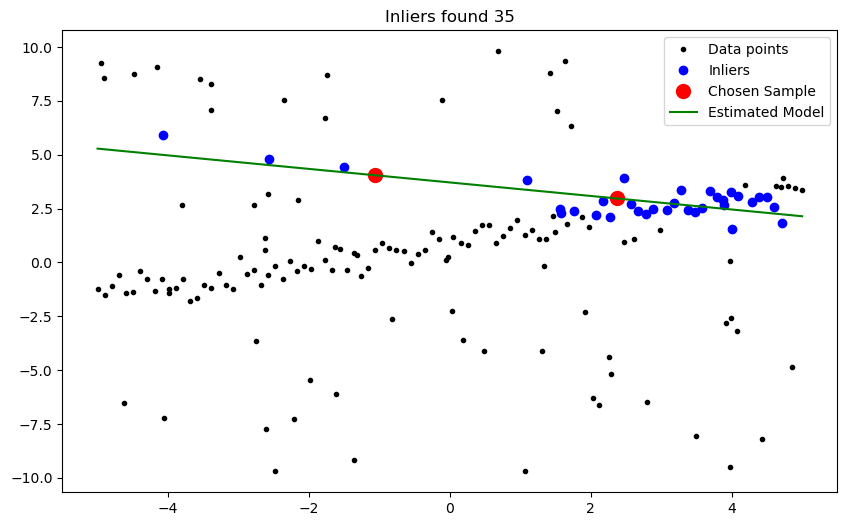

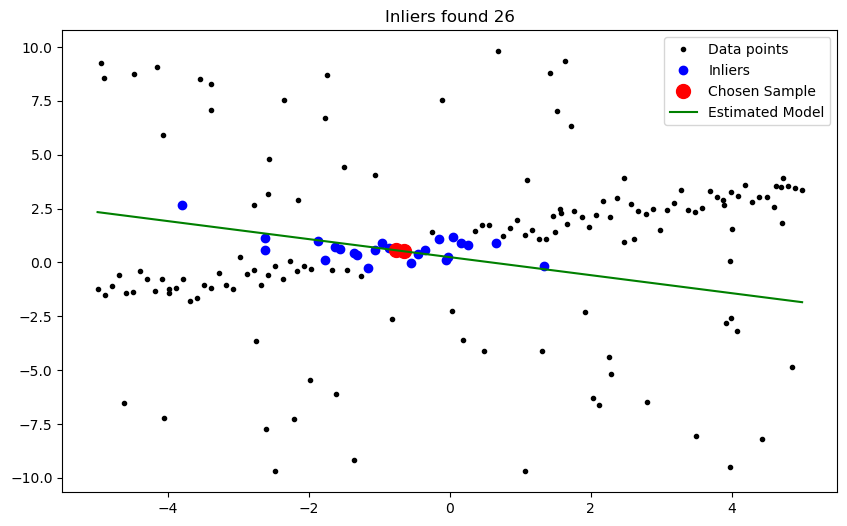

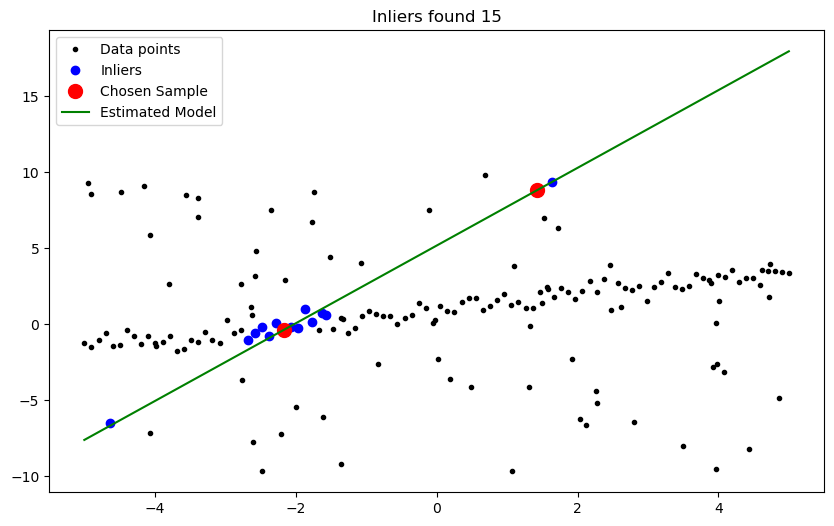

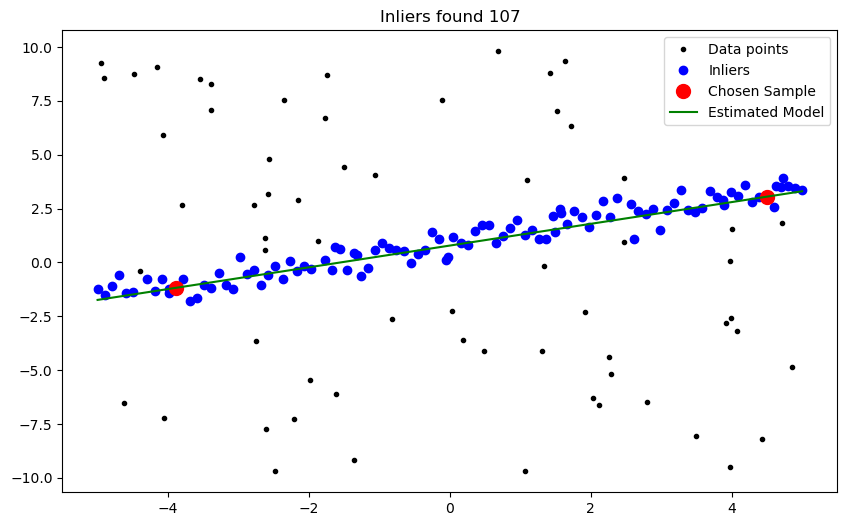

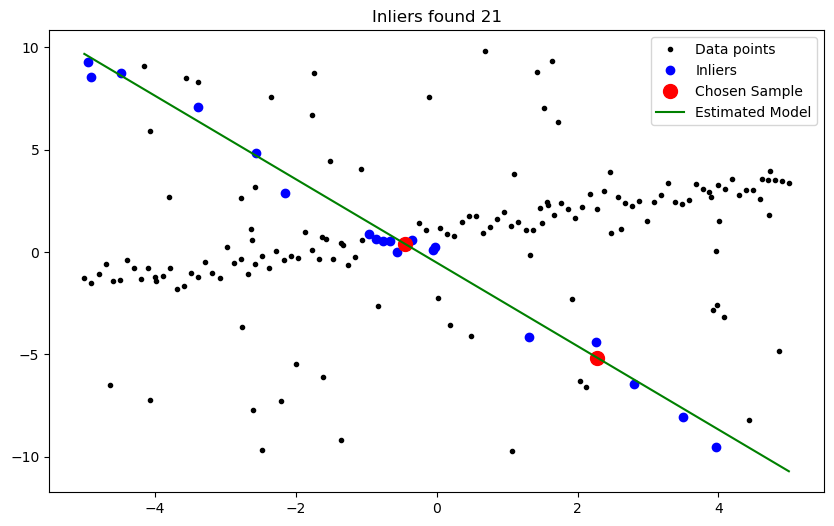

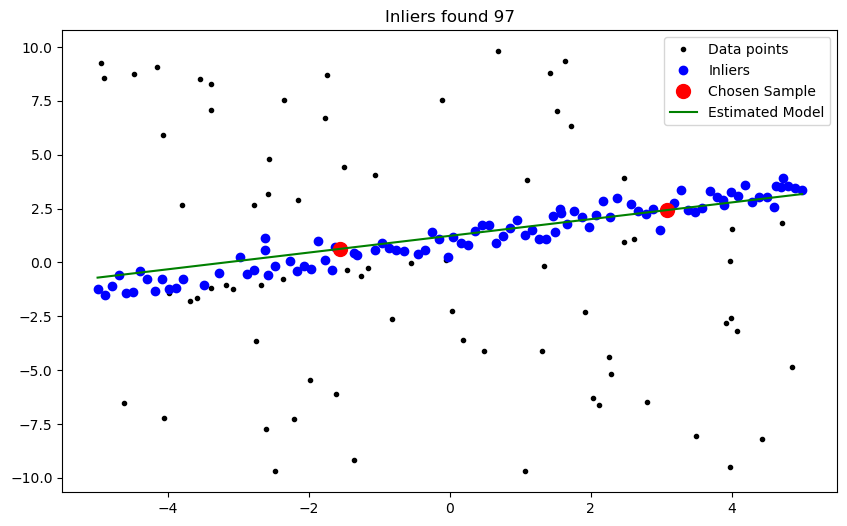

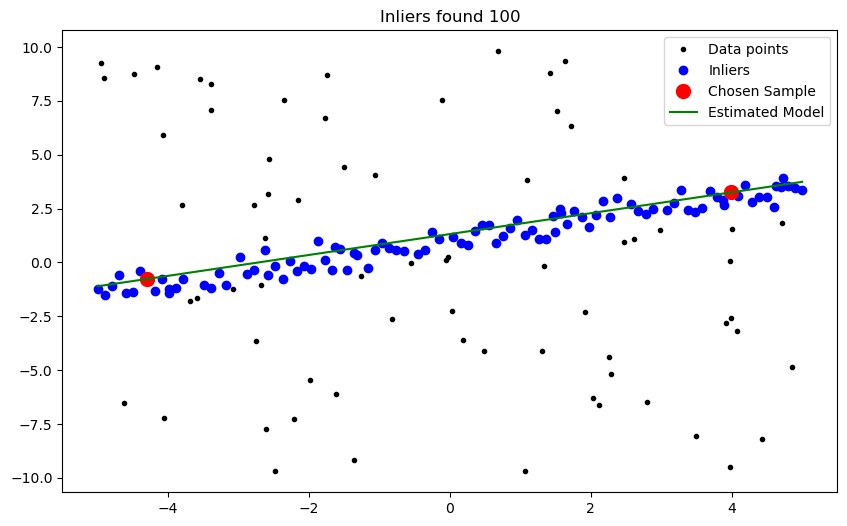

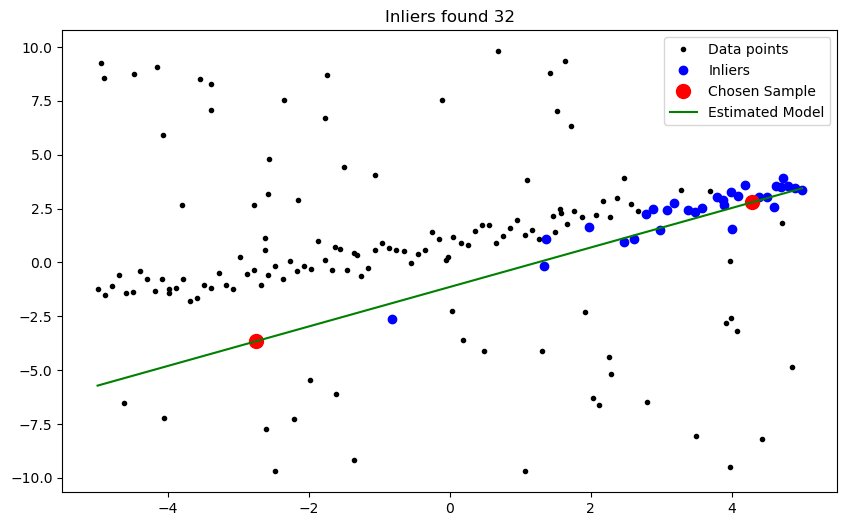

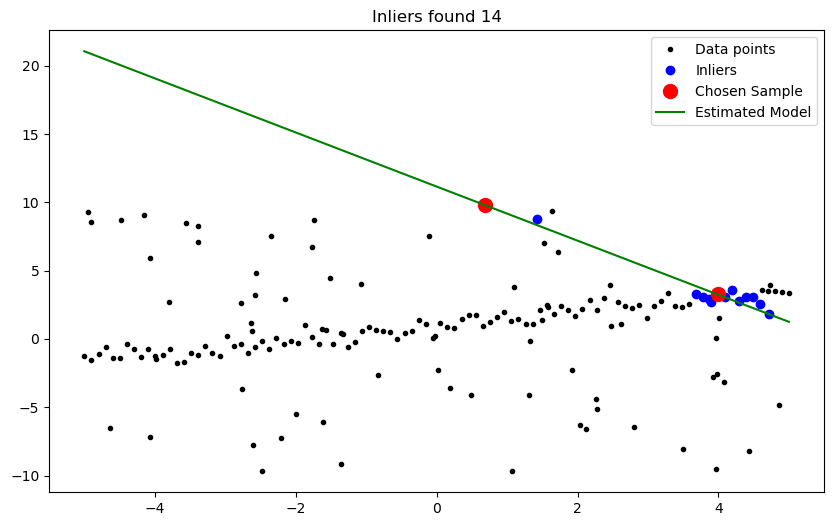

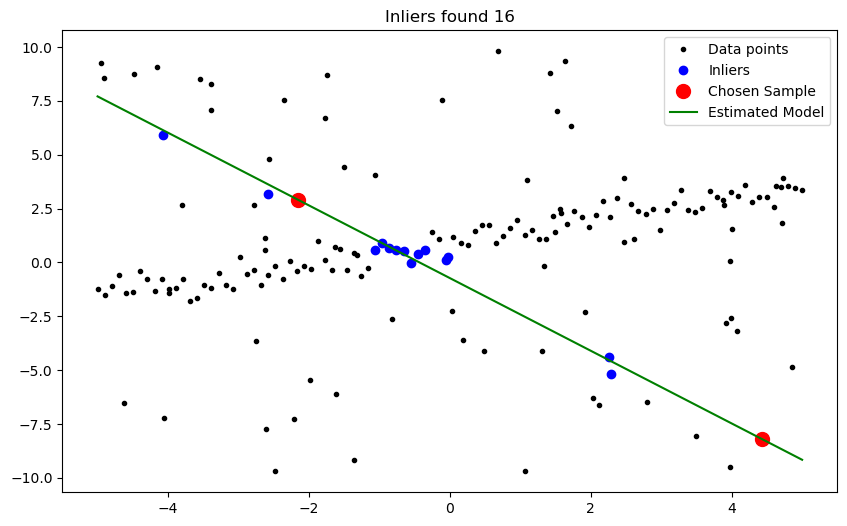

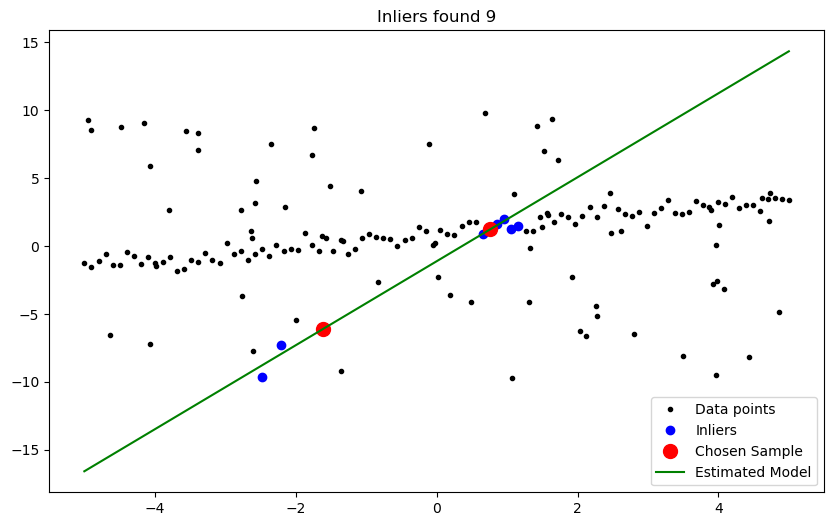

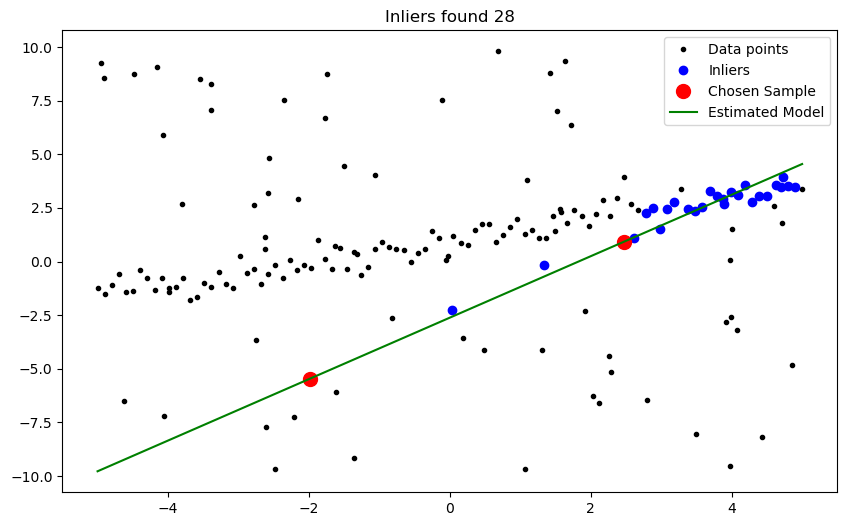

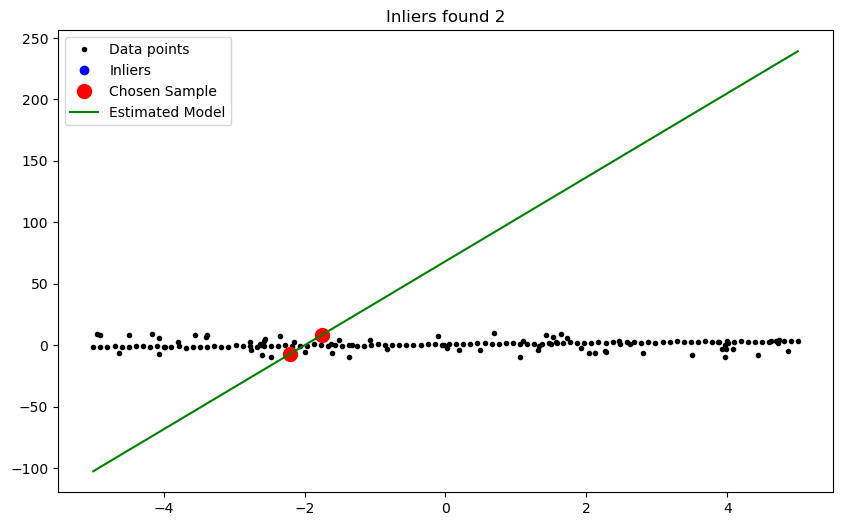

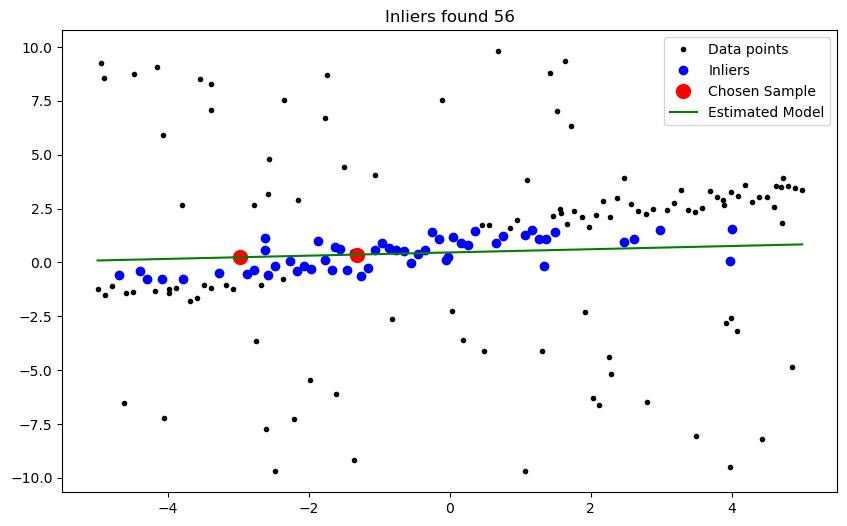

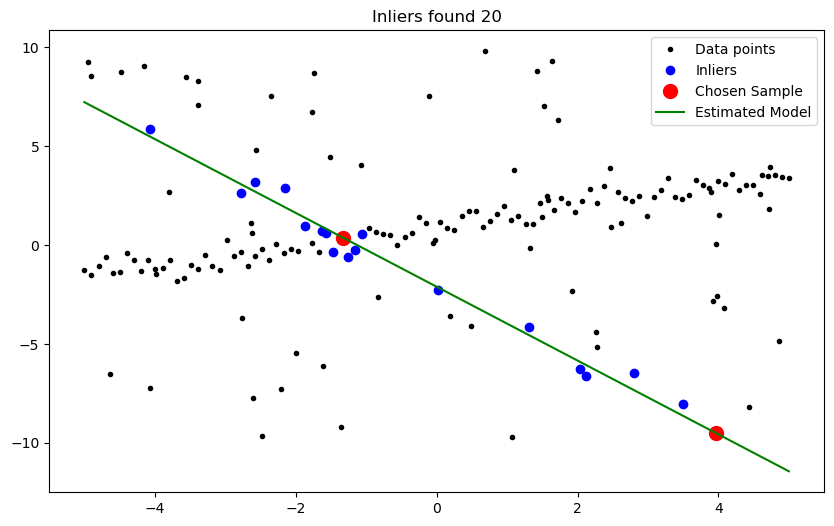

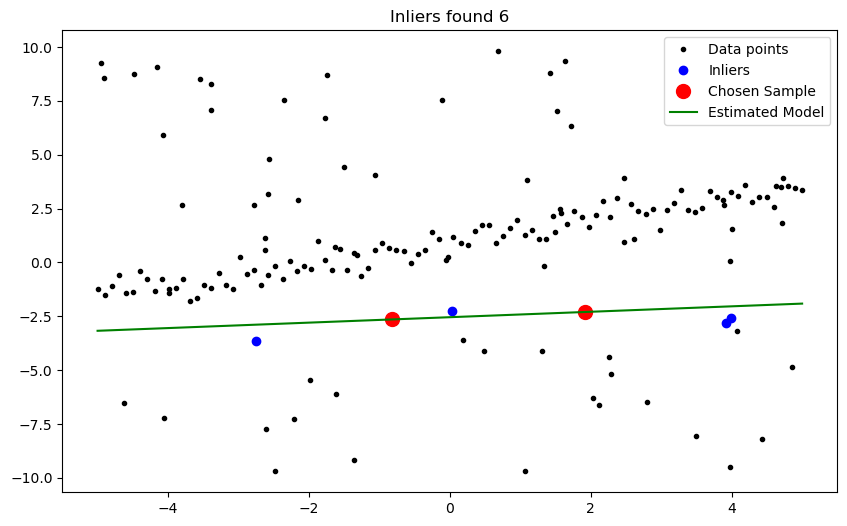

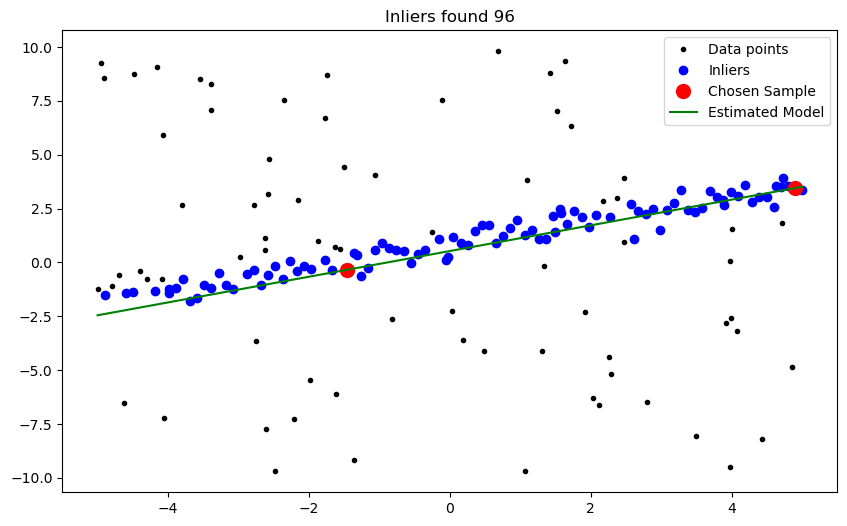

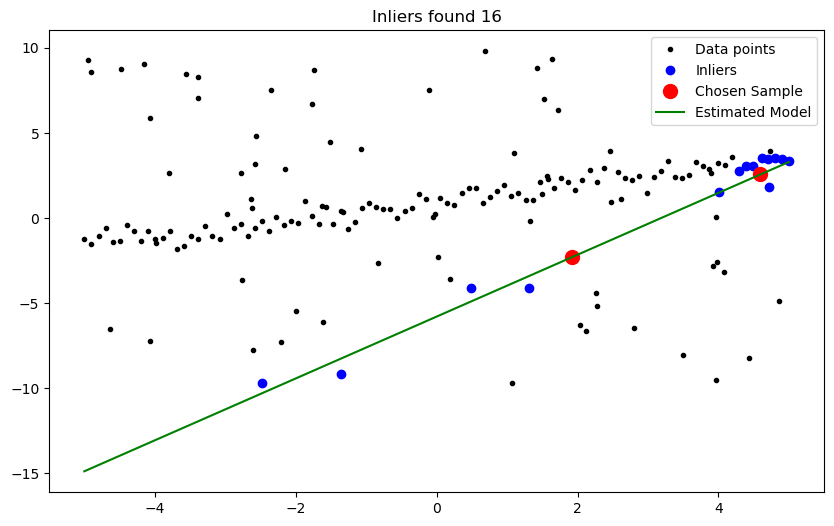

In [65]:
epochs = 20 
thres = 1.0 
min_inliers_to_stop = 80 
best_inliers = []


for epoch in range(epochs):
    #getting any 2 random data from the data stack 
    sample = data[np.random.choice(data.shape[0], 2)]
    x_sample, y_sample = sample[:, 0], sample[:, 1]
    A = np.vstack([x_sample, np.ones(len(x_sample))]).T
    m, b = np.linalg.lstsq(A, y_sample, rcond=None)[0]
    
    # Step 3: Compute inliers
    inliers = getInliers((m, b), data, thres)
    # print(inliers)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot all data points
    plt.plot(data[:, 0], data[:, 1], 'k.', label='Data points')

    # Highlight inliers
    inlier_array = np.array(inliers)
    if inlier_array.size > 0:
        plt.plot(inlier_array[:, 0], inlier_array[:, 1], 'bo', label='Inliers')

    # Highlight chosen sample
    plt.plot(x_sample, y_sample, 'ro', markersize=10, label='Chosen Sample')

    # Plot the estimated model
    x_range = np.linspace(min(data[:, 0]), max(data[:, 0]), 100)
    plt.plot(x_range, m * x_range + b, 'g-', label='Estimated Model')
    plt.title(f'Inliers found {len(inliers)}')
    plt.legend()
    plt.show()
    
# Update best model if current iteration is better
    if len(inliers) > len(best_inliers):
        best_inliers = inliers
        best_params = (m, b)
        
        # # Optional early stopping if enough inliers are found
        # if len(best_inliers) > min_inliers_to_stop:
        #     break
    
            
# Step 5: Re-estimate model parameters using all inliers if desired
if best_inliers:
    x_inliers, y_inliers = np.array(best_inliers).T
    A = np.vstack([x_inliers, np.ones(len(x_inliers))]).T
    m, b = np.linalg.lstsq(A, y_inliers, rcond=None)[0]
    best_params = (m, b)


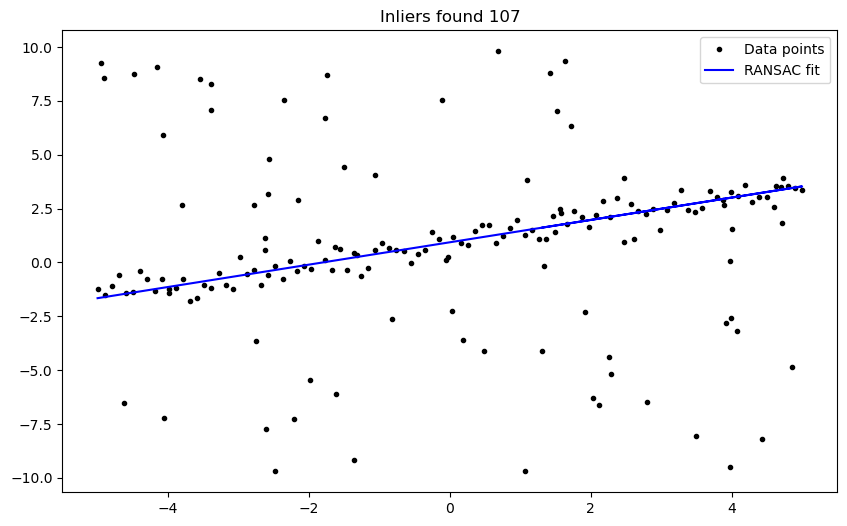

In [66]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'k.', label='Data points')
plt.plot(x, getY(best_params, x), 'b-', label='RANSAC fit')
plt.title(f'Inliers found {len(best_inliers)}')
plt.legend()
plt.show()